In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import getpass

user = getpass.getuser()

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime


/home/nsharma/miniconda3/envs/risingverse/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
startTime = datetime.now()

# generating df of anomalies between -5 to 20 in 1101 steps for each year between 2015 to 2100
temp_range = np.linspace(0.25, 4.25, 17)
idx = product(range(2015,2301), temp_range) 
temps = np.stack([temp_range for _ in range(2015,2301)]).flatten() 
temps = pd.DataFrame(temps, index=[i for i,x in idx], columns=['temp'])
temps = temps.reset_index().rename(columns={"index":"year"})
# temps # checking things out

In [3]:
# reading the coeffs in SSP2 and SSP3 to obtain damage functions

dataframes = {}

for df in ['nocons_df_old_SSP2', 'nocons_df_old_SSP3', 'nocons_df_new_SSP2', 'nocons_df_new_SSP3']:
    dataframes[df] = pd.read_csv(f'/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/SCC_diagnostics/{df}.csv')
    dataframes[df] = dataframes[df][["year", "cons","beta1","beta2"]]
    dataframes[df] = pd.merge(dataframes[df], temps, on= ['year'], how = 'inner') 
    dataframes[df][f'{df}_T'] = (dataframes[df].cons + dataframes[df].temp * dataframes[df].beta1 + dataframes[df].temp**2 * dataframes[df].beta2)

In [4]:
dataframes['nocons_df_new_SSP2']


,year,cons,beta1,beta2,temp,nocons_df_new_SSP2_T
0,2020,0,0.094844,-0.181717,0.25,0.012354
1,2020,0,0.094844,-0.181717,0.50,0.001993
2,2020,0,0.094844,-0.181717,0.75,-0.031083
3,2020,0,0.094844,-0.181717,1.00,-0.086873
4,2020,0,0.094844,-0.181717,1.25,-0.165377
...,...,...,...,...,...,...
4772,2300,0,4.317049,6.106793,3.25,78.533410
4773,2300,0,4.317049,6.106793,3.50,89.917886
4774,2300,0,4.317049,6.106793,3.75,102.065710
4775,2300,0,4.317049,6.106793,4.00,114.976884


In [5]:
years = list(range(2020, 2301, 10))

ssp2 = pd.merge(dataframes['nocons_df_old_SSP2'], dataframes['nocons_df_new_SSP2'], on = ['year', 'temp'], how = 'outer')
ssp2 = ssp2[ssp2['year'].isin(years)]

ssp3 = pd.merge(dataframes['nocons_df_old_SSP3'], dataframes['nocons_df_new_SSP3'], on = ['year', 'temp'], how = 'outer')
ssp3 = ssp3[ssp3['year'].isin(years)]

old = pd.merge(dataframes['nocons_df_old_SSP2'], dataframes['nocons_df_old_SSP3'], on = ['year', 'temp'], how = 'outer')
old = old[old['year'].isin(years)]

new = pd.merge(dataframes['nocons_df_new_SSP2'], dataframes['nocons_df_new_SSP3'], on = ['year', 'temp'], how = 'outer')
new = new[new['year'].isin(years)]

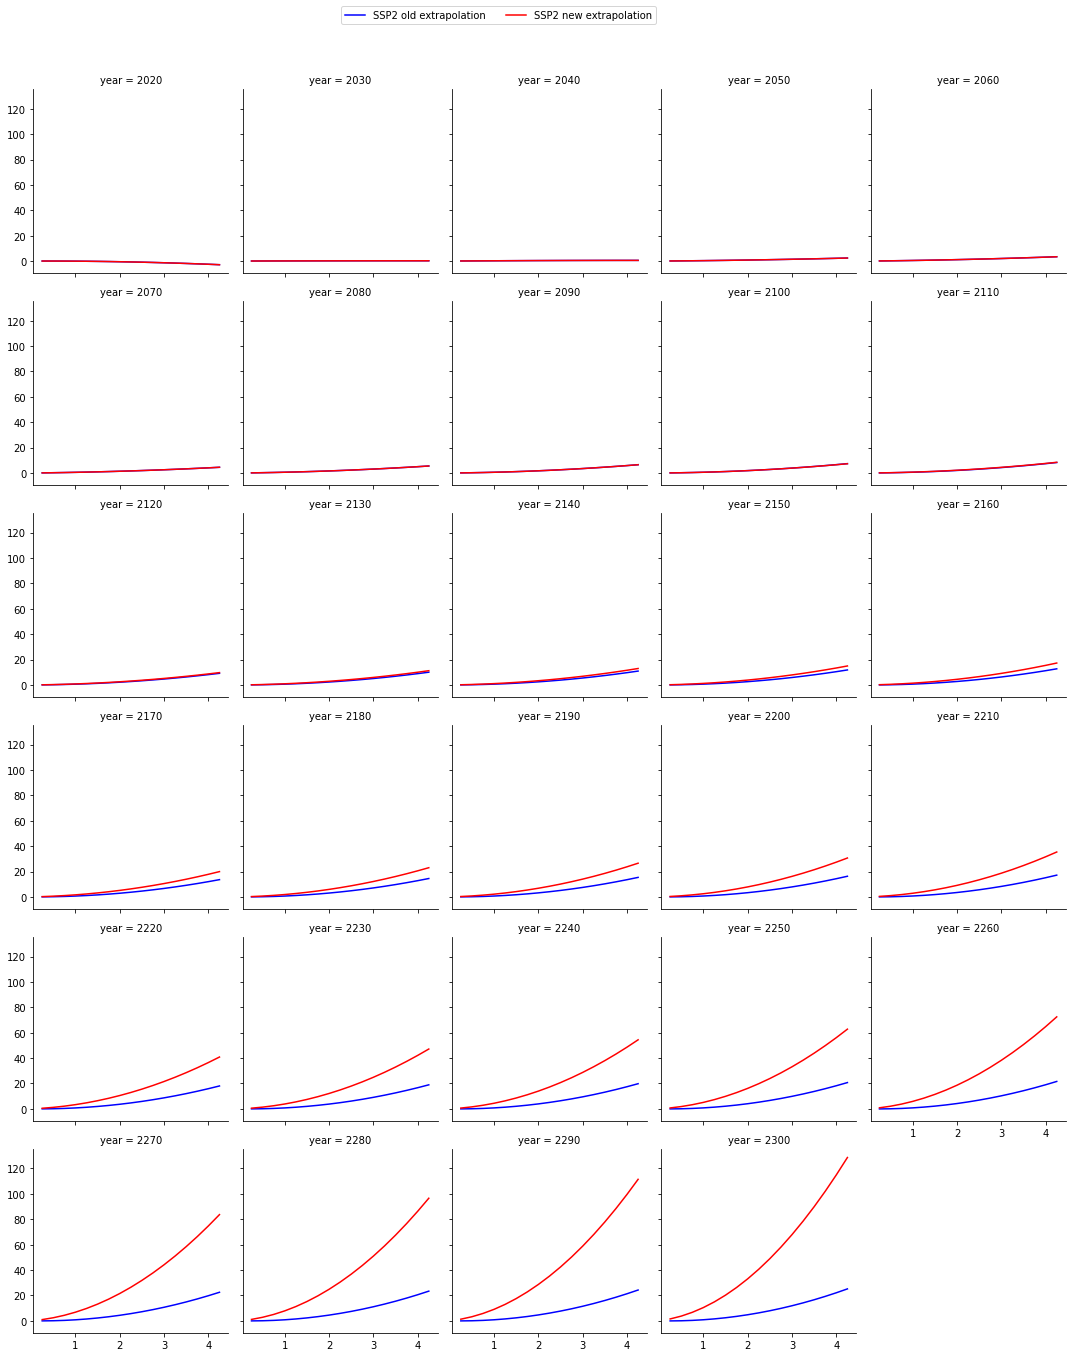

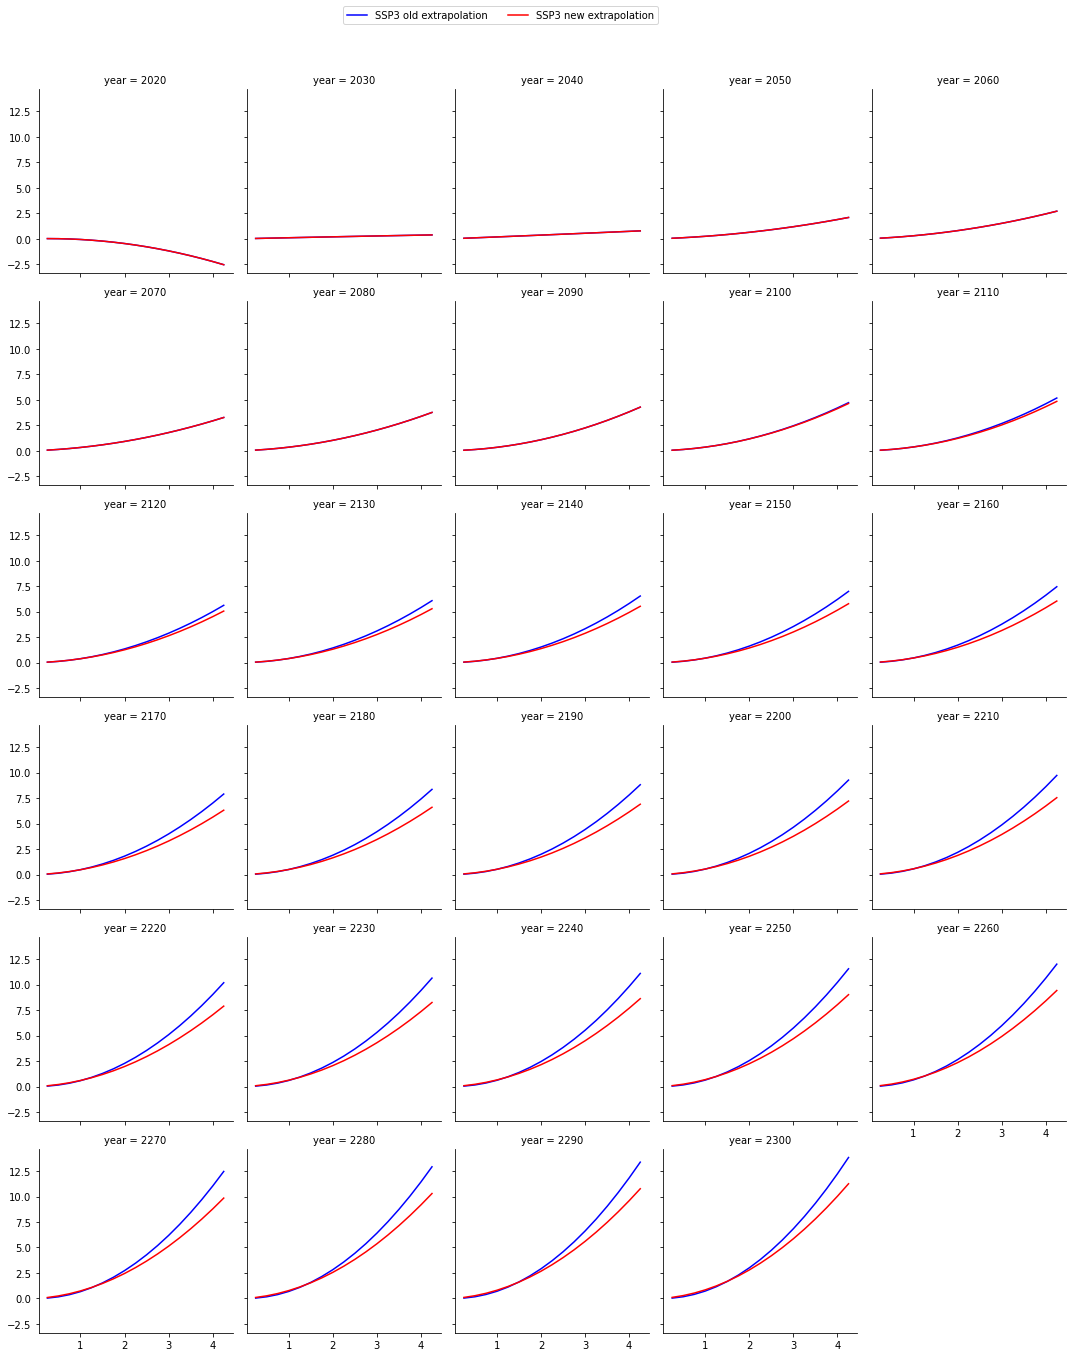

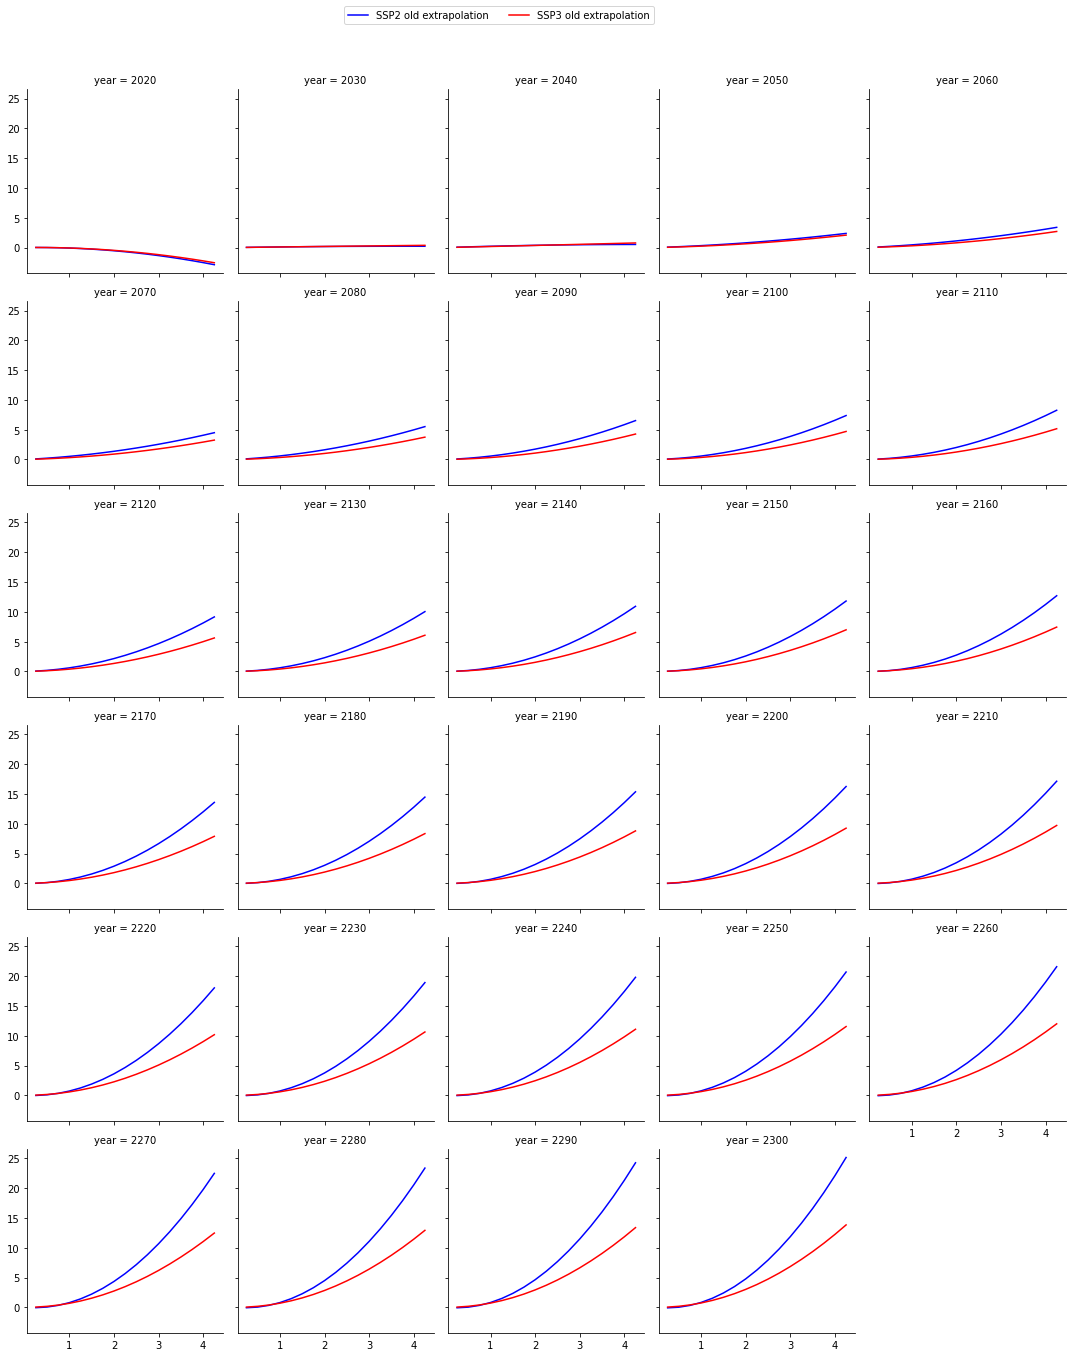

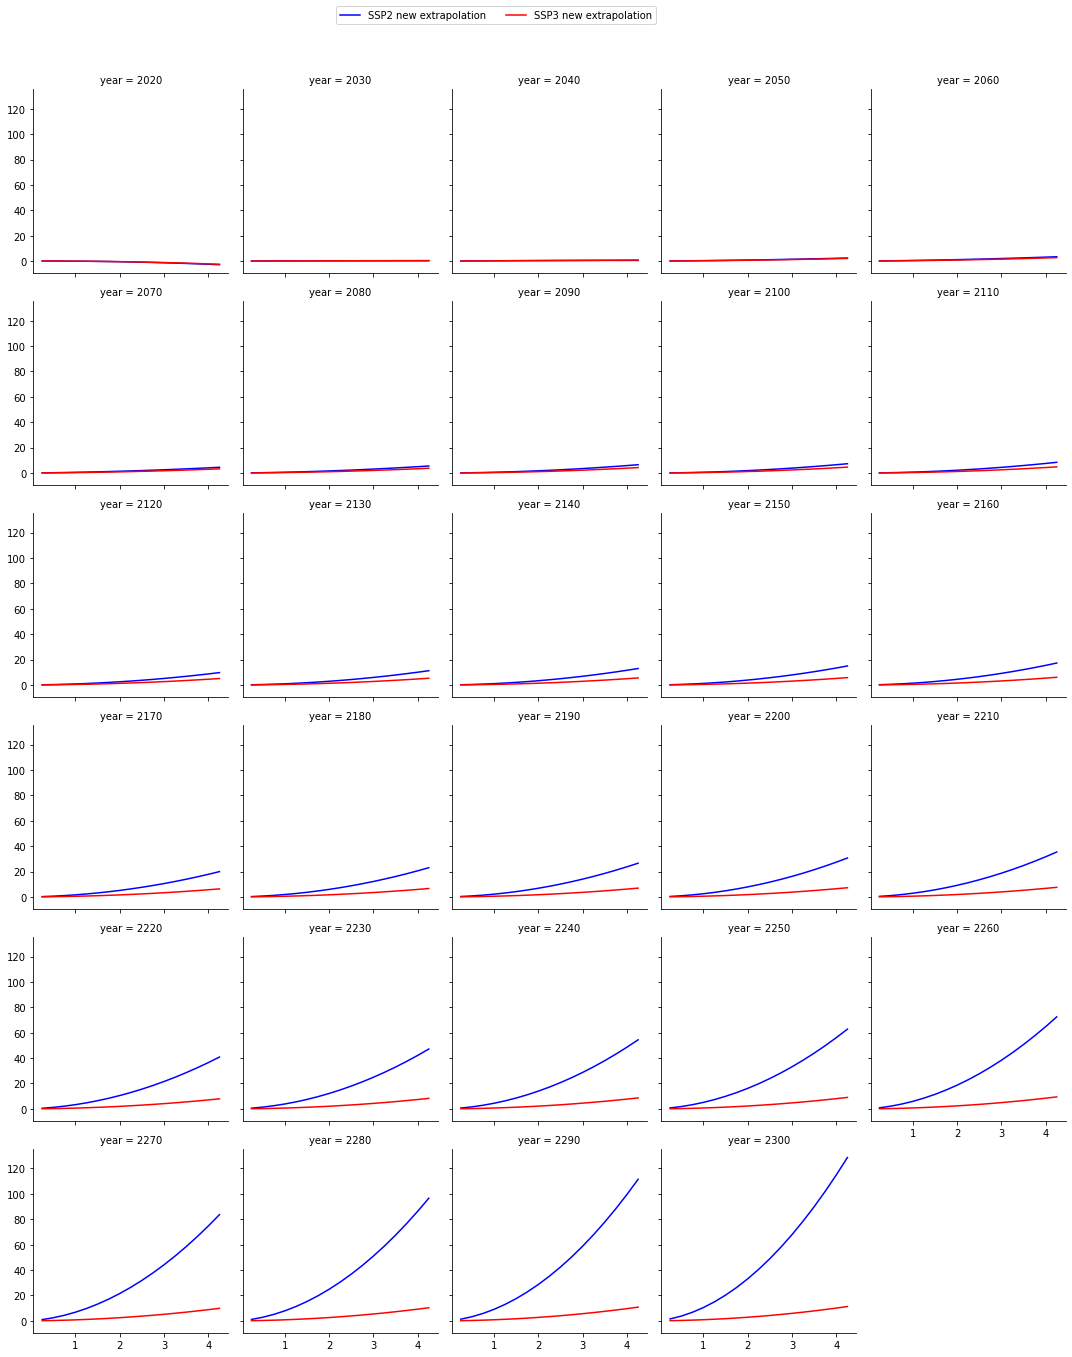

In [6]:
def plot(df, filename, y1, label1, y2, label2, savepath = '/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/SCC_diagnostics/'):
   g = sns.FacetGrid(df, col="year", col_wrap=5, sharey=True)
   g.map_dataframe(sns.lineplot, x='temp', y=y1, color = "blue", label=label1)
   g.map_dataframe(sns.lineplot, x='temp', y=y2, color = "red", label=label2)
   lgd = plt.legend(bbox_to_anchor=(0,7.25), ncol=2)
   plt.savefig(f'{savepath}/{filename}', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


plot(ssp2, filename='ssp2.pdf', y1 = 'nocons_df_old_SSP2_T', label1 = "SSP2 old extrapolation", y2 = 'nocons_df_new_SSP2_T', label2 = "SSP2 new extrapolation" )

plot(ssp3, filename='ssp3.pdf', y1 = 'nocons_df_old_SSP3_T', label1 = "SSP3 old extrapolation", y2 = 'nocons_df_new_SSP3_T', label2 = "SSP3 new extrapolation" )

plot(old, filename='old.pdf', y1 = 'nocons_df_old_SSP2_T', label1 = "SSP2 old extrapolation", y2 = 'nocons_df_old_SSP3_T', label2 = "SSP3 old extrapolation" )

plot(new, filename='new.pdf', y1 = 'nocons_df_new_SSP2_T', label1 = "SSP2 new extrapolation", y2 = 'nocons_df_new_SSP3_T', label2 = "SSP3 new extrapolation" )


In [7]:
print(datetime.now() - startTime)

0:00:28.938655
